In [37]:
# Import packages
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy import ndimage
import scipy.io as sio
from scipy.signal import butter, sosfilt

In [2]:
# Check data
base_dir = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence'

data_dir = os.path.join(base_dir, 'data')
fig_dir = os.path.join(os.path.join(base_dir, 'figures'), 'Fig3')

data_path = os.path.join(data_dir, 'Fig3_ver01_221025_data119.cathodic.dF.dFF')

test = sio.loadmat(data_path)
test

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Oct 25 18:34:27 2022',
 '__version__': '1.0',
 '__globals__': [],
 'data119_cathodic_dF': array([[[-144.8, -130.8, -154.8, ..., -210.8, -228.8, -228.8],
         [-165.2, -145.2, -137.2, ..., -295.2, -283.2, -289.2],
         [-148.8, -100.8, -144.8, ..., -196.8, -268.8, -274.8],
         ...,
         [-118. ,  -90. , -112. , ..., -150. , -192. , -190. ],
         [-116. , -150. , -124. , ..., -212. , -218. , -216. ],
         [-144.8, -148.8, -150.8, ..., -198.8, -194.8, -216.8]],
 
        [[-124.4, -126.4, -156.4, ..., -206.4, -204.4, -198.4],
         [-131.2, -133.2, -129.2, ..., -243.2, -225.2, -245.2],
         [-123.6, -121.6, -151.6, ..., -179.6, -251.6, -245.6],
         ...,
         [-134. , -148. , -142. , ..., -158. , -196. , -218. ],
         [-149.2, -161.2, -129.2, ..., -217.2, -231.2, -223.2],
         [-142.4, -150.4, -148.4, ..., -176.4, -188.4, -188.4]],
 
        [[-157.2, -145.2, -159.2, ..

In [3]:
# Check keys
test.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data119_cathodic_dF', 'data119_cathodic_dFF'])

In [4]:
# Print out shapes, min and max values
print(test['data119_cathodic_dF'].shape)

print(test['data119_cathodic_dF'].min())
print(test['data119_cathodic_dF'].max())

print(test['data119_cathodic_dFF'].shape)

print(test['data119_cathodic_dFF'].min())
print(test['data119_cathodic_dFF'].max())

(80, 80, 5000)
-456.0
-16.799999999999955
(80, 80, 5000)
-0.329004329004329
-0.014856738592147112


In [5]:
# The F0 value will be somewhere between these two below values.
print(test['data119_cathodic_dF'].max() / test['data119_cathodic_dFF'].min())
print(test['data119_cathodic_dF'].min() / test['data119_cathodic_dFF'].max())

51.063157894736705
30693.14285714294


In [6]:
# Temporal processing

## Low-pass filtering (10 hz)
lowcut = 10.
fs = 1000.
sos = butter(5, [lowcut], 'low', fs=fs, output='sos')
temp_data = sosfilt(sos, test['data119_cathodic_dF'])

print(temp_data.shape)
print(temp_data.min())
print(temp_data.max())

(80, 80, 5000)
-206.1061422525224
-1.594869933543148e-06


In [75]:
# Spatial processing

## Low-pass filtering (3x3 mean, 3 iter.)
kernel = np.array([[[1/9, 1/9, 1/9],
                   [1/9, 1/9, 1/9],
                   [1/9, 1/9, 1/9]]]) # (1, 3, 3)
space_data1 = ndimage.convolve(temp_data, kernel)

## Movie scaling
space_data2_temp = np.swapaxes(temp_data, 0, -1)
space_data2 = (space_data2_temp - space_data2_temp.min(axis=0)) / (space_data2_temp.max(axis=0) - space_data2_temp.min(axis=0))
space_data2 *= 255

## Coloring
level_num = 4.
one_interval = 255 / level_num
space_data3 = space_data2 / one_interval
space_data3 = np.floor(space_data3)
space_data3[space_data3 >= level_num] = level_num - 1
space_data3 *= one_interval
space_data3 += (one_interval / 2)
unique, counts = np.unique(space_data3, return_counts=True)
print(unique, counts)

print(space_data3.shape)
print(space_data3.min())
print(space_data3.max())

[ 31.875  95.625 159.375 223.125] [31395042   230174    83636   291148]
(5000, 80, 80)
31.875
223.125


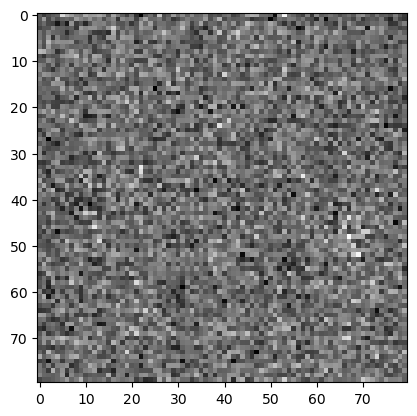

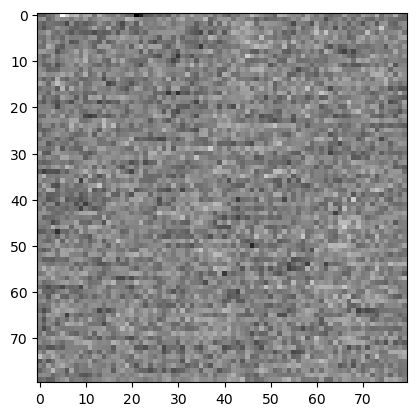

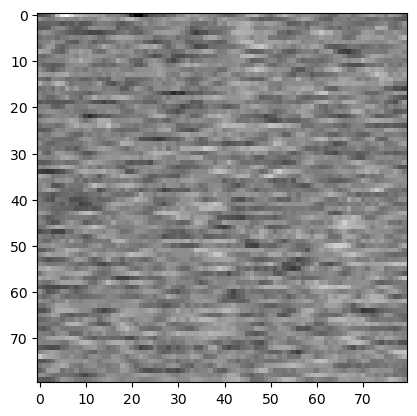

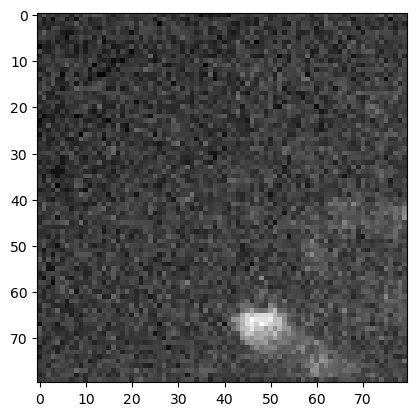

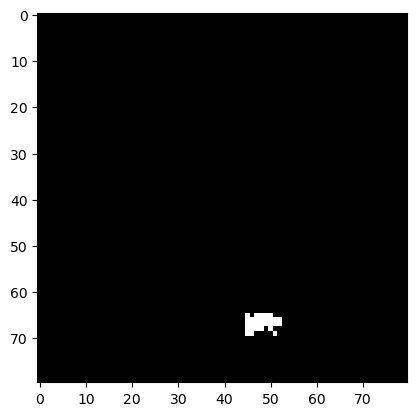

In [8]:
# Visualize one frame for full processing steps
frame_num = 1647 # 1447 or 1647

plt.imshow(test['data119_cathodic_dF'][:, :, frame_num], cmap='gray')
plt.show()

plt.imshow(temp_data[:, :, frame_num], cmap='gray')
plt.show()

plt.imshow(space_data1[:, :, frame_num], cmap='gray')
plt.show()

plt.imshow(space_data2[frame_num, :, :], cmap='gray')
plt.show()

plt.imshow(space_data3[frame_num, :, :], cmap='gray')
plt.show()

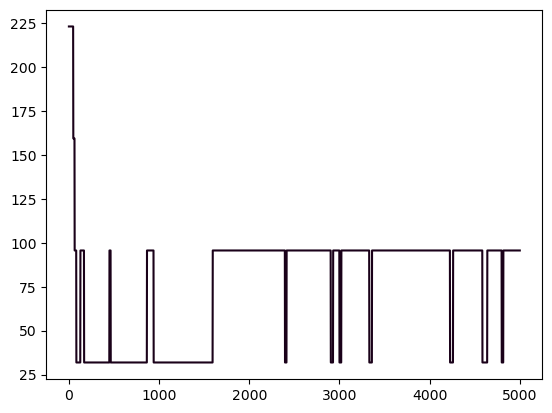

In [139]:
plt.plot(space_data3[:, 65, 49])
plt.show()

In [131]:
# Make binary numpy array to describe hyperpolarization phenomenon
DorH = 'Hyperpolarizatoin' # 'Depolarization'

dic = {'x_coord':[], 'y_coord':[], 'frame_num':[]}
new_data = space_data3.copy()
for x_coord in range(space_data3.shape[1]):
    for y_coord in range(space_data3.shape[-1]):
        for frame_num in range(1, space_data3.shape[0]):
            old_data = space_data3[frame_num-1, x_coord, y_coord]
            new_data = space_data3[frame_num, x_coord, y_coord]
            print(old_data, new_data)
            print('hi')
            if DorH == 'Depolarization':
                if old_data > new_data:
                    dic['x_coord'].append(x_coord)
                    dic['y_coord'].append(y_coord)
                    dic['frame_num'].append(frame_num)
            elif DorH == 'Hyperpolarization':
                if old_data < new_data:
                    dic['x_coord'].append(x_coord)
                    dic['y_coord'].append(y_coord)
                    dic['frame_num'].append(frame_num)

df = pd.DataFrame.from_dict(dic)
df.to_csv(os.path.join(fig_dir, f'{DorH}.csv'), index=False)

223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 223.125
hi
223.125 159.375
hi
159.375 159.375
hi
159.375 159.375
hi
159.375 159.375
hi
159.375 159.375
hi
159.375 159.375
hi
159.375 159.375
hi
159.375 159.

KeyboardInterrupt: 

In [130]:
dic

{'x_coord': [], 'y_coord': [], 'frame_num': []}

In [116]:
if DorH == 'Depolarization':
    colors = ['#3dff00', '#008cfd']
elif DorH == 'Hyperpolarization':
    colors = ['#3dff00', '#ff1203'] # '#1a0119', '#008cfd', '#3dff00', '#ff1203'

for frame_num in list(np.unique(df['frame_num'].values)):
    mini_df = df[df['frame_num']==frame_num]
    if mini_df.shape[0] >= 4:
        x_mean, y_mean = mini_df.mean(axis=0)['x_coord'], mini_df.mean(axis=0)['y_coord']
        circle = Circle((y_mean, x_mean), mini_df.std(axis=0).max(), color='yellow', alpha=0.5)

        fig, ax = plt.subplots(1)
        ax.set_aspect('equal')
        ax.imshow(space_data3[frame_num, :, :], matplotlib.colors.ListedColormap(colors))
        # ax.add_patch(circle)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.title(f'Frame {frame_num}')
        # plt.show()
        # for i in range(mini_df.shape[0]):
        #     print(f'(x, y)=({mini_df.iloc[i, 0]}, {mini_df.iloc[i, 1]})')
        plt.savefig(f'c:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\figures\\Fig3\\{DorH}\\{frame_num}.png')

[223.125]


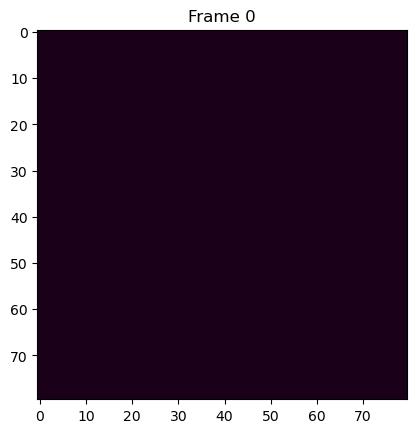

[31.875]


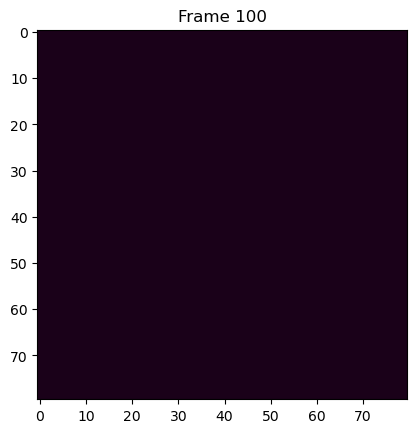

[31.875 95.625]


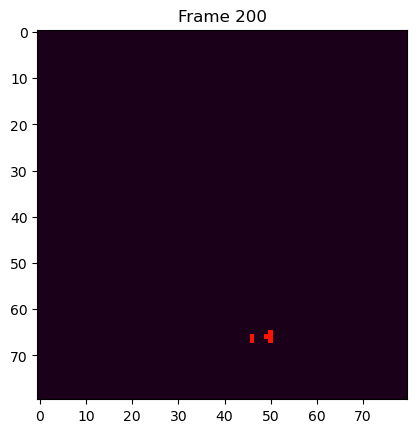

[31.875 95.625]


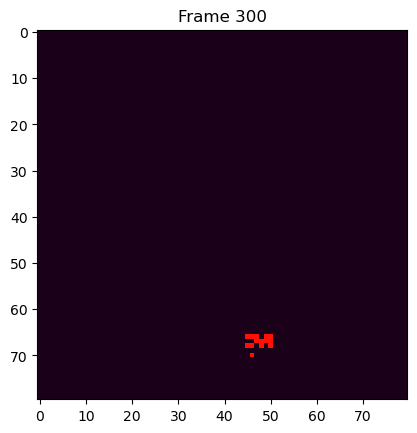

[31.875 95.625]


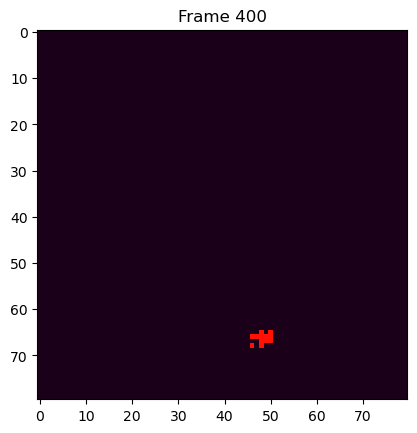

[31.875 95.625]


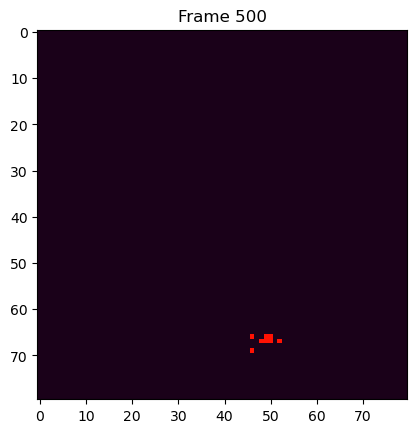

[31.875 95.625]


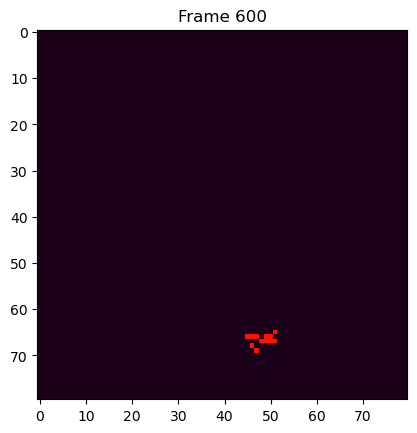

[31.875 95.625]


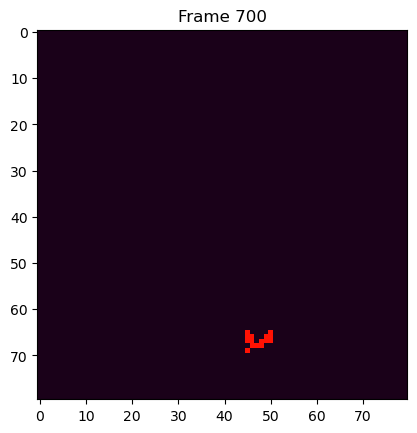

[31.875 95.625]


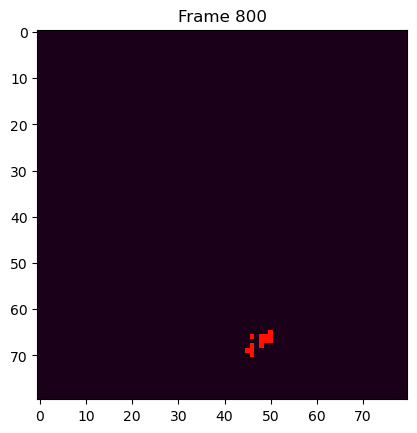

[31.875 95.625]


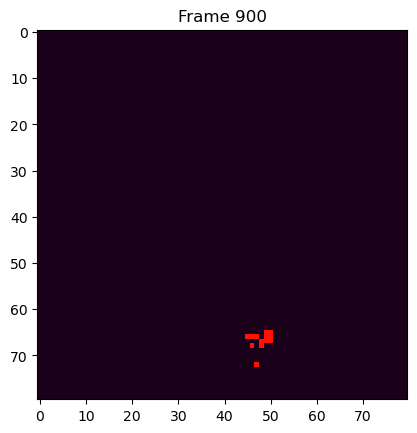

[31.875 95.625]


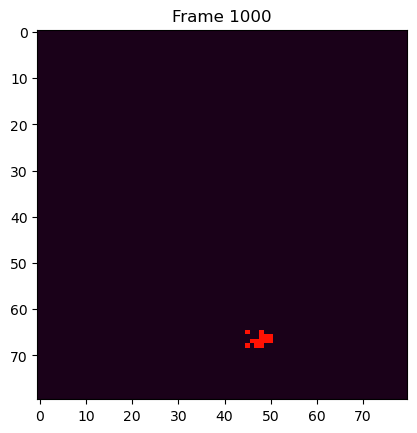

[31.875]


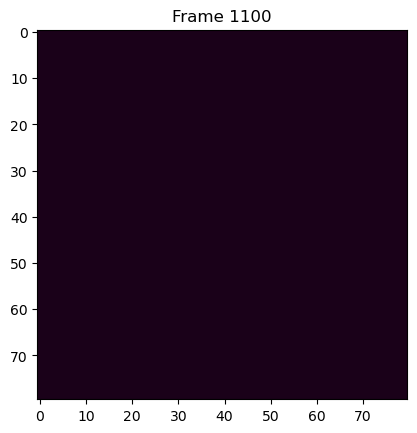

[31.875]


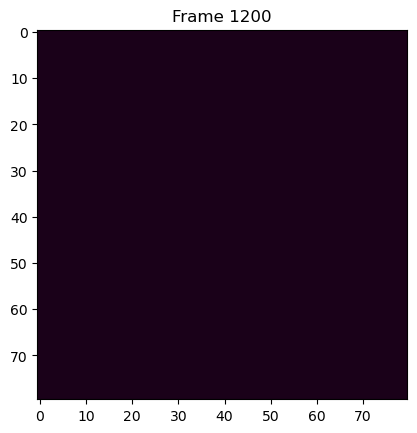

[31.875]


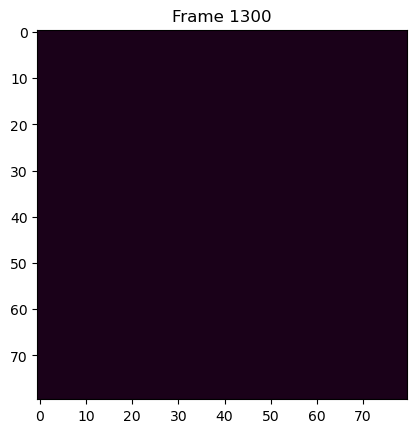

[31.875]


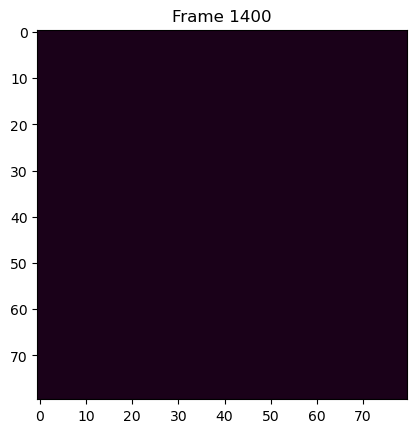

[31.875]


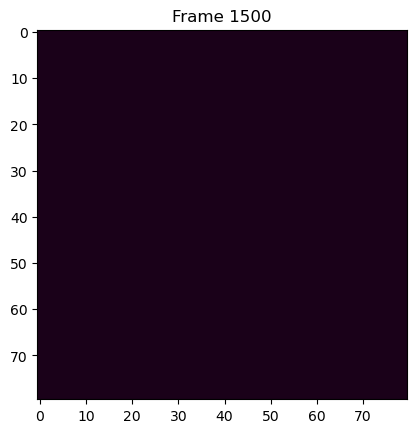

[31.875 95.625]


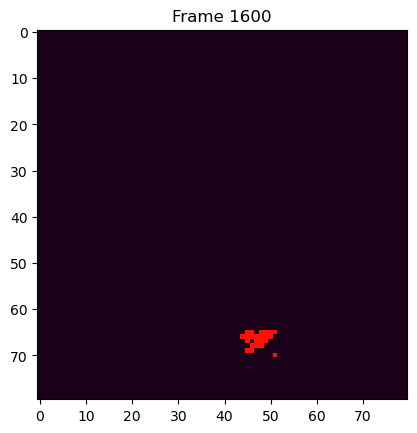

[31.875 95.625]


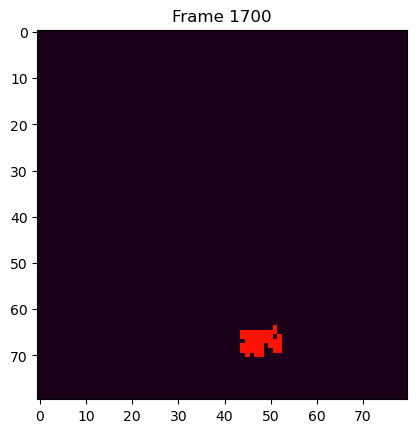

[31.875 95.625]


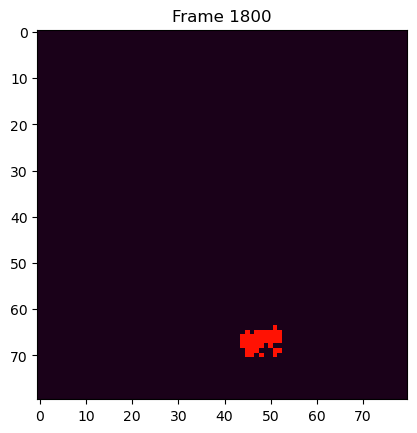

[31.875 95.625]


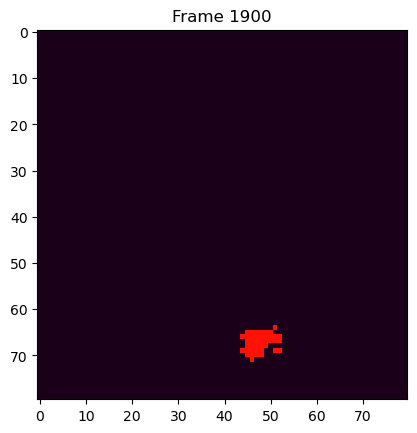

[31.875 95.625]


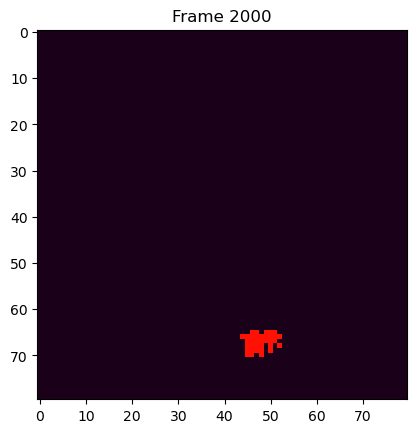

[31.875 95.625]


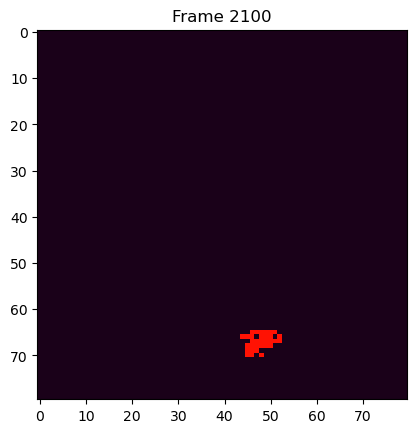

[31.875 95.625]


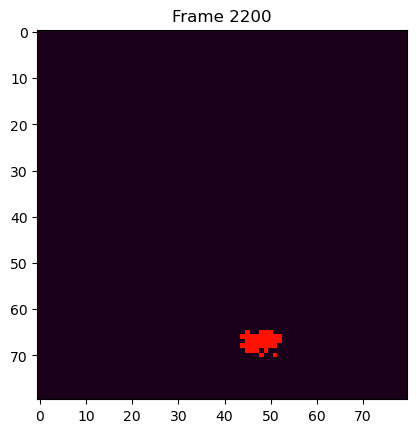

[31.875 95.625]


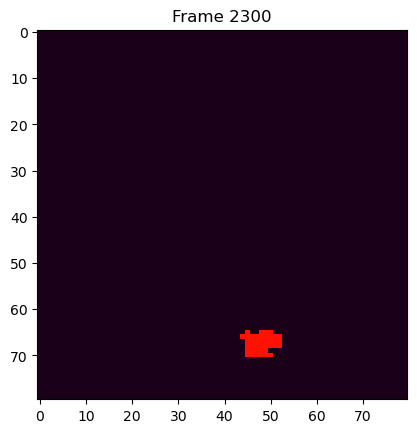

[31.875 95.625]


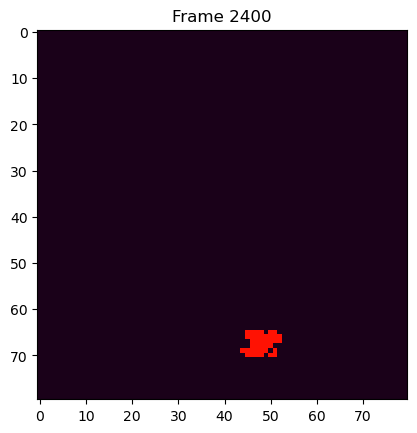

[31.875 95.625]


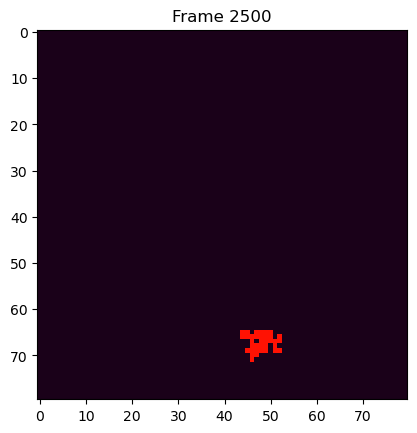

[31.875 95.625]


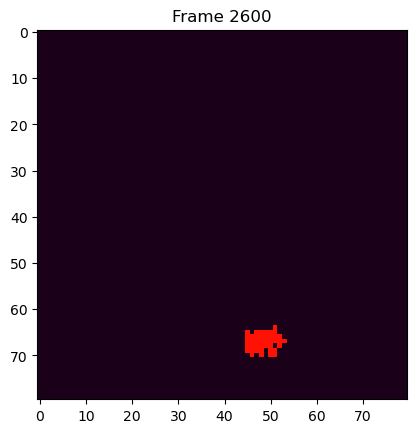

[31.875 95.625]


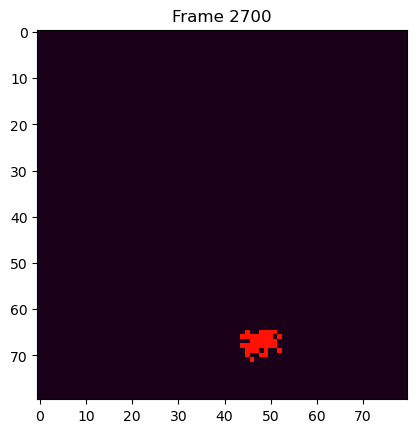

[31.875 95.625]


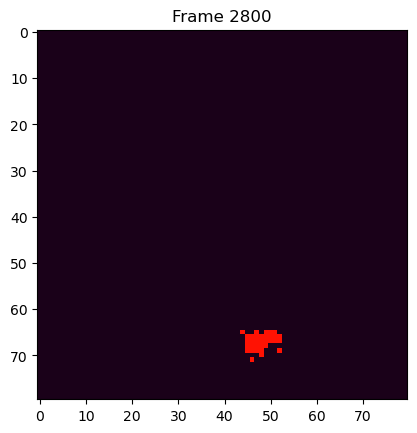

[31.875 95.625]


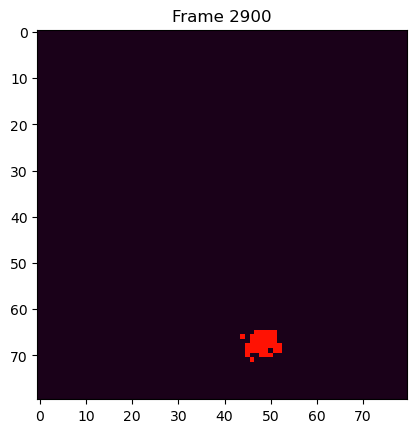

[31.875 95.625]


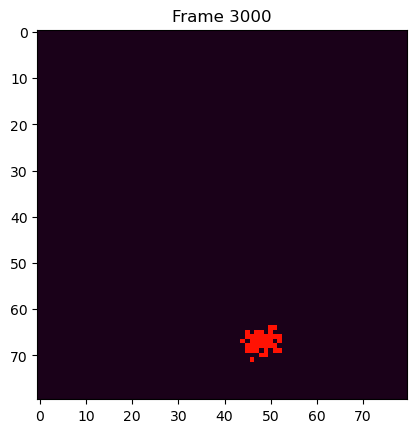

[31.875 95.625]


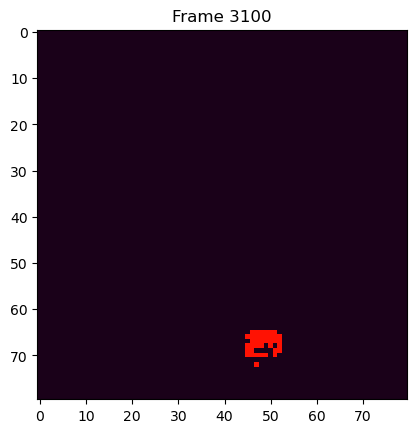

[31.875 95.625]


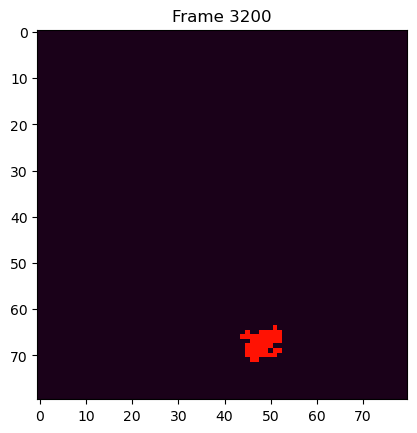

[31.875 95.625]


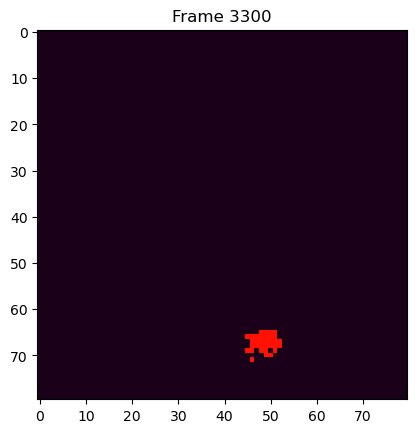

[31.875 95.625]


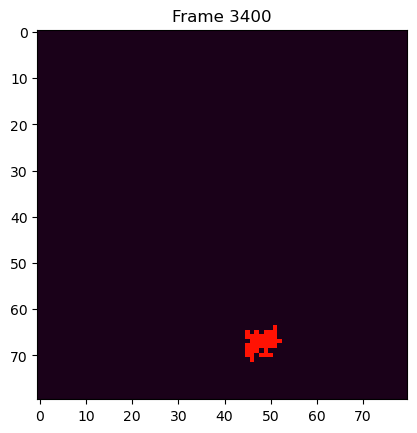

[31.875 95.625]


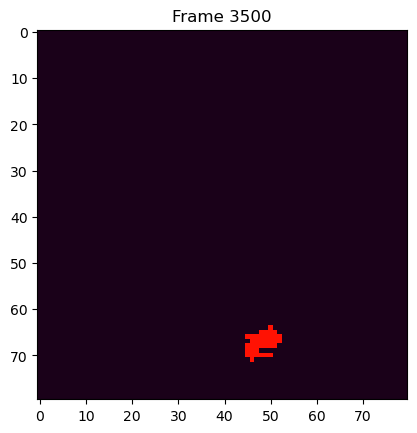

[31.875 95.625]


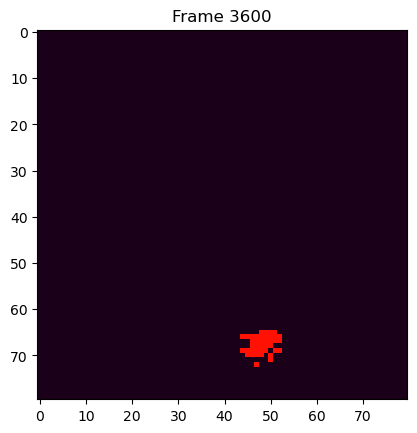

[31.875 95.625]


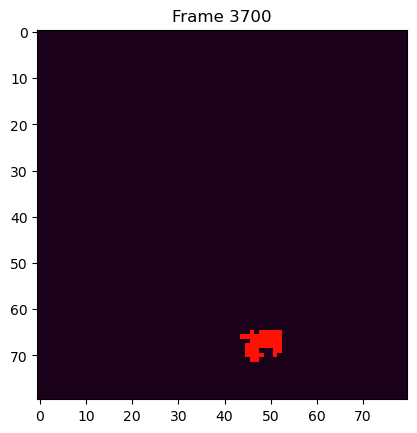

[31.875 95.625]


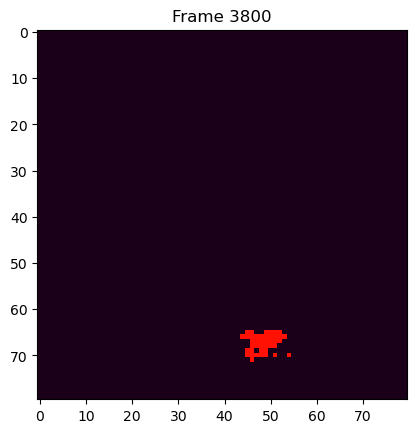

[31.875 95.625]


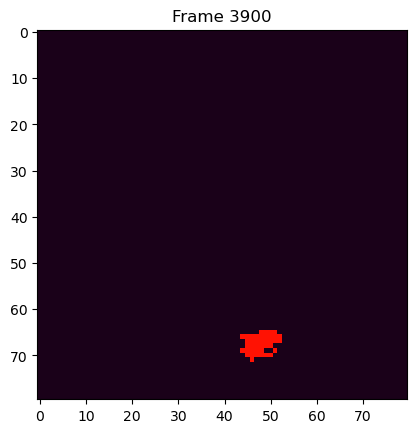

[31.875 95.625]


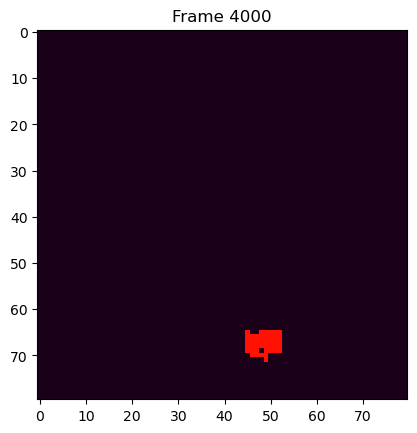

[31.875 95.625]


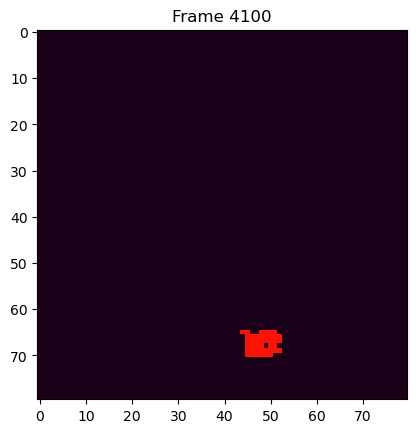

[31.875 95.625]


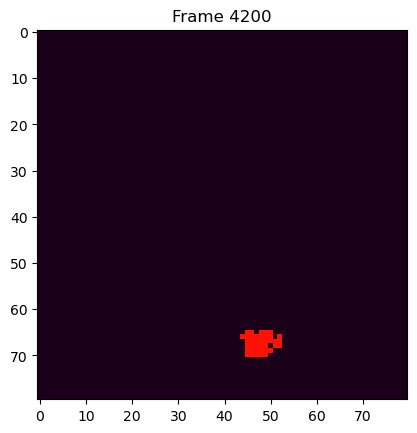

[31.875 95.625]


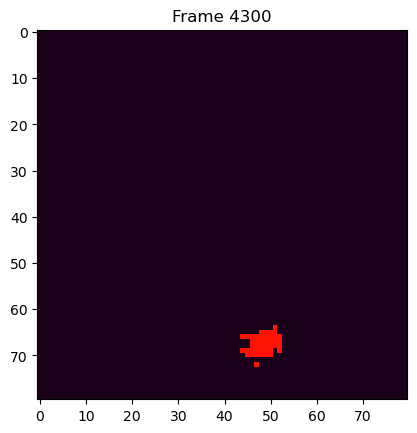

[31.875 95.625]


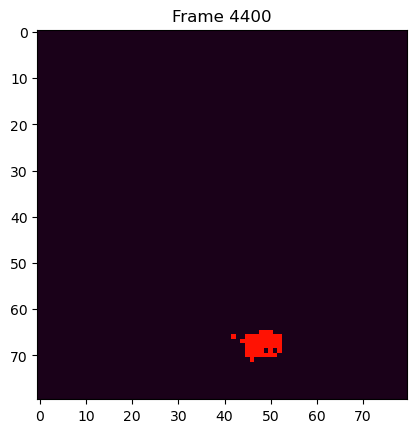

[31.875 95.625]


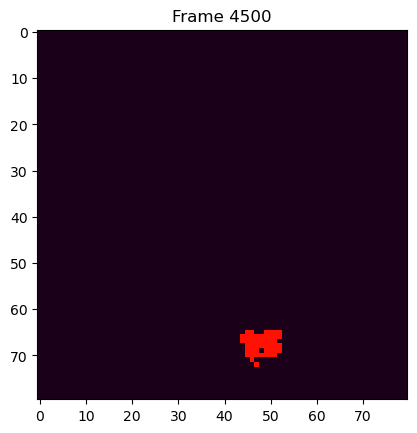

[31.875 95.625]


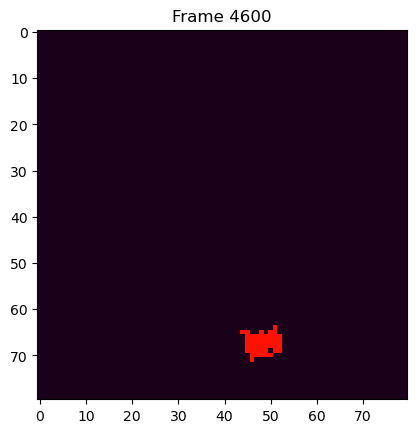

[31.875 95.625]


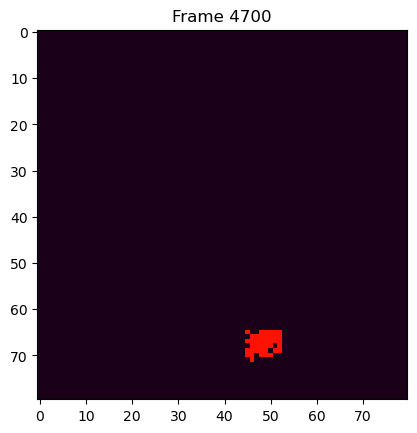

[31.875 95.625]


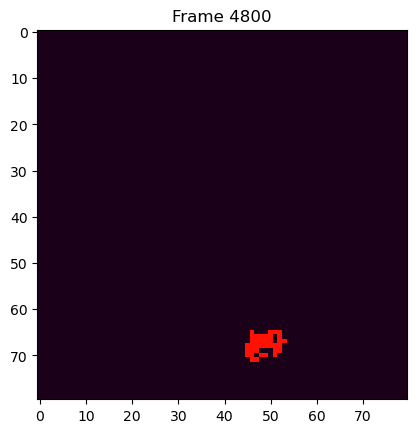

[31.875 95.625]


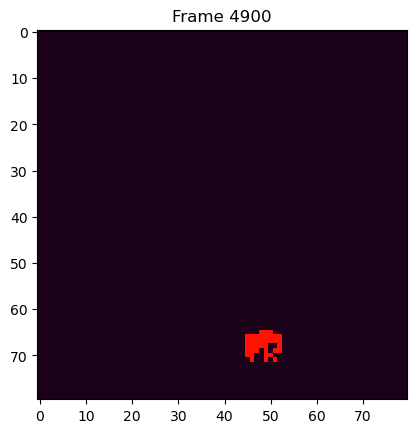

In [124]:
data = space_data3
colors = ['#1a0119', '#008cfd', '#3dff00', '#ff1203']
for frame_num in range(0, data.shape[0], 100):
    # print(np.unique(space_data3[frame_num, :, :]))
    plt.imshow(space_data3[frame_num, :, :], cmap=matplotlib.colors.ListedColormap(colors))
    plt.title(f'Frame {frame_num}')
    plt.savefig(f'c:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\figures\\Fig3\\Frames\\{frame_num}.png')
    plt.show()